In [1]:
import numpy as np
import gym
from gym import spaces
from numpy import float32
import tensorflow as tf
import random
import numpy as np
import scipy.io as sio
import pickle as pk
import sys
import os
from gym.error import DependencyNotInstalled
from typing import Optional
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import normalize
import pandas as pd
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO
from stable_baselines3 import SAC
from stable_baselines3 import DDPG
from stable_baselines3 import TD3

import keras

from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.noise import NormalActionNoise


from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import matplotlib.pyplot as plt

from ipynb.fs.defs.TrainingEnv import CarFollowingEnv
from ipynb.fs.defs.TestingEnv import CarFollowingEnv_test
from ipynb.fs.defs.TestingEnvRecurrent import CarFollowingEnv_test_recurrent

from imitation.algorithms.bc import reconstruct_policy 
from ipynb.fs.defs.DataLoader import data_loader
from ipynb.fs.defs.DataLoader import driver_classifier_TTC

import torch
from tqdm import tqdm
import time

In [2]:
from math import sqrt

#NRMSE function suitable for the models.

def NRMSE_batch(y_true, y_pred):

    T = len(y_true)
    sse = np.array([0.0])
    true_sse = np.array([0.0])
    
    for i in range(T):
        sse = tf.cast(sse, tf.float64) + tf.cast((y_true[i] - y_pred[i])**2, tf.float64)
        true_sse = tf.cast(true_sse, tf.float64) + tf.cast((y_true[i])**2, tf.float64)
        
    RMSE = tf.math.sqrt((1/T)*sse)
    NRMSE = RMSE/tf.math.sqrt((1/T)*true_sse)
    
    return NRMSE

In [3]:
def real_pos(obs_data):
    
    real_pos_data = [0.0]
    
    for i in range(1, len(obs_data)):
        
        pos = real_pos_data[i-1] + obs_data[i-1,1]*0.1
        real_pos_data.append(pos)
        
    return real_pos_data       

In [5]:
# CF Environment INITIALIZATION, TESTING, and VECTORIZATION.
# Vectorization is used to run the Imitation algorithms.

env = CarFollowingEnv_test()
check_env(env, warn=True)
env = make_vec_env(lambda: env, n_envs=1)

In [6]:
####################################### Reinforcement Learning #######################################

#PPO tuned hyperparameters.
env = CarFollowingEnv()

model_PPO = PPO(env = env,
    policy= 'MlpPolicy', 
    batch_size= 128,
    n_steps= 128,
    gamma= 0.9999,
    learning_rate= 1e-04/2.0,
    ent_coef= 0.00429,
    clip_range= 0.1,
    n_epochs= 10,
    gae_lambda= 0.9,
    max_grad_norm= 5,
    vf_coef= 0.19,
    use_sde= True,
    verbose = 0,
    policy_kwargs = dict(log_std_init=-3.29, ortho_init=False))


In [141]:
#DDPG tuned hyperparameters
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise
env = CarFollowingEnv()

action_noise2 = OrnsteinUhlenbeckActionNoise(mean = np.array([0.0]),  sigma= np.array([0.5]))

model_DDPG = DDPG(env = env,
            policy = "MlpPolicy",
            batch_size = 64,
            action_noise = action_noise2,
            verbose = 1)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [146]:
#TD3 tuned hyperparameters
env = CarFollowingEnv()

action_noise2 = OrnsteinUhlenbeckActionNoise(mean = np.array([0.0]),  sigma= np.array([0.5]))

model_TD3 = TD3(env = env,
               policy = "MlpPolicy",
               batch_size = 64,
               action_noise = action_noise2,
                verbose = 1)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [8]:
#Recurrent PPO
from sb3_contrib import RecurrentPPO

model_rPPO = RecurrentPPO(env = env,
    policy= 'MlpLstmPolicy', 
    batch_size= 64,
    n_steps= 8,
    gamma= 0.9999,
    learning_rate= 7.77e-05,
    ent_coef= 0.00429,
    clip_range= 0.1,
    n_epochs= 10,
    gae_lambda= 0.9,
    max_grad_norm= 5,
    vf_coef= 0.19,
    use_sde= True,
    verbose = 1,
    device = "cuda",
    policy_kwargs = dict(log_std_init=-3.29, ortho_init=False))

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [42]:
# Tuned SAC
env = CarFollowingEnv()
action_noise = NormalActionNoise(mean = np.array([0.0]), sigma= np.array([0.1]))
action_noise2 = OrnsteinUhlenbeckActionNoise(mean = np.array([0.0]),  sigma= np.array([0.5]))


model_SAC = SAC(env = env,
  policy= 'MlpPolicy',
  learning_rate = 3e-4,
  buffer_size= 50000,
  batch_size= 64,
  ent_coef= 0.1,
  train_freq= 32,
  gradient_steps= 32,
  gamma= 0.9999,
  tau= 0.01,
  learning_starts= 0,
  use_sde= True,
  action_noise = action_noise2,
  policy_kwargs= dict(log_std_init=-3.67, net_arch=[64, 64]))

In [55]:
#Rewards
env = CarFollowingEnv()
test_env = CarFollowingEnv_test()

mean_reward, std_reward = evaluate_policy(model_PPO, test_env, n_eval_episodes=100)

print(f"Mean reward BEFORE training:{mean_reward:.2f} +/- {std_reward:.2f}")

Mean reward BEFORE training:-1029.88 +/- 1360.03


In [ ]:
eval_callback = EvalCallback(test_env, eval_freq=300, best_model_save_path='./Test repertory/',
                             deterministic=True, render=False)

model_PPO.learn(total_timesteps=100000, callback = eval_callback)

In [50]:
#Rewards
env = CarFollowingEnv()
test_env = CarFollowingEnv_test()

mean_reward, std_reward = evaluate_policy(FINAL_AIRL, test_env, n_eval_episodes=100)

print(f"Mean reward AFTER training:{mean_reward:.2f} +/- {std_reward:.2f}")

Mean reward AFTER training:77.15 +/- 71.60


In [8]:
model.save("...")

In [7]:
#FINAL TRAINED MODELS

MODEL_SAC = SAC.load("./BestModelSAC/best_model")

FINAL_BC = reconstruct_policy("BestModelBC 10 traj act -3 3")

FINAL_FNN = keras.models.load_model("BestModelFFN30 -3 3 NRMSE FINAL", custom_objects={"NRMSE_batch": NRMSE_batch})

FINAL_RNN = keras.models.load_model("BestModelRNN30 -3 3 FINAL NRMSE", custom_objects = {"NRMSE_batch": NRMSE_batch})

FINAL_GAIL = PPO.load("BestModelGAIL 10 traj LR 1e-04 div 2 act -3 3")

FINAL_AIRL = PPO.load("BestModelAIRL 15 traj LR 5e-05 acc -3 3")

In [5]:
#Rewards
env = CarFollowingEnv()
test_env = CarFollowingEnv_test()

mean_reward, std_reward = evaluate_policy(MODEL_AIRL, test_env, n_eval_episodes=100)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

C:\Users\Lucas Mtb\anaconda3\lib\site-packages\stable_baselines3\common\evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward:-11.72 +/- 120.31


In [8]:
df_TTC_list, drivers_TTC, drivers_perc_TTC, aggressive_drivers, neutral_drivers, timid_drivers, flop3_ag, flop3_tim = driver_classifier_TTC()

In [9]:
len(aggressive_drivers)

109

In [10]:
len(timid_drivers)

112

In [12]:
### CODE TO TEST A SINGLE MODEL ###

env = CarFollowingEnv_test()
#env = CarFollowingEnv_test_recurrent()

#Choose the number of testing episodes:
#total_episode = 109 #aggressive 
#total_episode = 112 #timid 
total_episode = 403 #Every testing driver

rolling_window = 20

inds_done = []

episode_score = np.zeros(total_episode)  # average score of each car following event
cum_collision_num = np.zeros(total_episode)
rolling_score = np.zeros(total_episode)
rolling_NRMSE = np.zeros(total_episode)

score_safe = np.zeros(total_episode)
score_efficiency = np.zeros(total_episode)
score_comfort = np.zeros(total_episode)
score_NRMSE = np.zeros(total_episode)
score_RMSE = np.zeros(total_episode)
actions = np.zeros(total_episode)

sim_data = []
pos_data = []
reward_data = []
car_fol_ids = []

df_TTC_list, drivers_TTC, drivers_perc_TTC, aggressive_drivers, neutral_drivers, timid_drivers, flop3_ag, flop3_tim = driver_classifier_TTC()

driving_style = "all"


for i in tqdm(range(total_episode), desc = "Trajectory generation ... "):
    
    new_ind = False 
    
    while not new_ind: #The trajectory is generated only if it refers to a new testing CF event. 
        
        s = env.reset()
        j = env.car_fol_id
        
        if driving_style == "aggressive":
    
            while j not in aggressive_drivers:
                s = env.reset()
                j = env.car_fol_id
            
        elif driving_style == "neutral":

            while j not in neutral_drivers:
                s = env.reset()
                j = env.car_fol_id
    
        elif driving_style == "timid":

            while j not in timid_drivers:
                s = env.reset()
                j = env.car_fol_id
        
        if j not in inds_done:
            inds_done.append(j)
            new_ind = True
            
    #print("Random traj selected:",j)
    
    score = 0
    score_s, score_e, score_c, score_nrmse, a = 0, 0, 0, 0, 0  # part objective scores
    score_rmse = 0
    collision_test = 0

    
    while True:
        # Add exploration noise
        action, _states = MODEL_SAC.predict(s) #Choose which model to test.
        #action = FINAL_FNN(s.reshape(1,3)) 
        #action = FINAL_RNN(s.reshape(1, 50, 3)) 
        s_, reward, done, info = env.step(action)
        
        reward_data.append(info) #!!!
        s = s_
        score += reward
        score_s += info["fTTC"]
        score_e += info["fHdw"]
        score_c += info["fJerk"]
        score_nrmse += info["fNRMSE"]
        a += action
        score_rmse += info["RMSE"]
        
        
        if done:
            duration = env.TimeLen
            score /= duration  # normalize with respect to the CF event length.
            score_s /= duration
            score_e /= duration
            score_c /= duration
            score_nrmse /= duration
            a /= duration
            score_rmse /= duration

            if env.isCollision == 1:
                collision_test += 1
            break
        
    # store traffic simulation data
    sim_data.append(np.vstack((env.LVSpdData, env.SimSpeedData, env.SimSpaceData, env.SimTTCData)).T)
    pos_data.append(np.vstack((env.SimPosData, env.LVPosData, env.SimSpaceData, env.SimTTCData)).T)
    
    car_fol_ids.append(env.car_fol_id)

    # record episode results
    episode_score[i] = score
    score_safe[i] = score_s
    score_efficiency[i] = score_e
    score_comfort[i] = score_c
    score_NRMSE[i] = score_nrmse
    score_RMSE[i] = score_rmse
    actions[i] = a
    rolling_score[i] = np.mean(episode_score[max(0, i - rolling_window + 1):i + 1])
    rolling_NRMSE[i] = np.mean(score_NRMSE[max(0, i - rolling_window + 1):i + 1])
    cum_collision_num[i] = collision_test

Trajectory generation ... : 100%|██████████| 403/403 [05:14<00:00,  1.28it/s]


In [13]:
print("Number of collisions:", int(sum(cum_collision_num)))

Number of collisions: 1


In [14]:
print(round(np.mean(episode_score), 3), "+/-", round(np.std(episode_score),3))

0.354 +/- 0.191


In [15]:
print(round(np.mean(score_safe),3), "+/-", round(np.std(score_safe),3))

-0.001 +/- 0.009


In [16]:
print(round(np.mean(score_comfort),4), "+/-", round(np.std(score_comfort),4))

-0.0002 +/- 0.0001


In [17]:
print(round(np.mean(score_efficiency),3), "+/-", round(np.std(score_efficiency),3))

0.612 +/- 0.061


In [18]:
print(round(-np.mean(score_NRMSE),3), "+/-", round(np.std(score_NRMSE),3))

0.255 +/- 0.17


In [19]:
print(round(np.mean(score_RMSE),3), "+/-", round(np.std(score_RMSE),3))

3.631 +/- 3.289


Text(0, 0.5, 'Acceleration (m/s^2)')

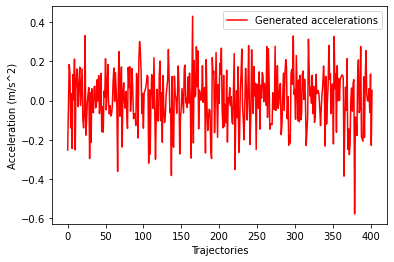

In [20]:
plt.figure()

plt.plot(actions, label = "Generated accelerations", color = "red")

plt.legend()

plt.xlabel('Trajectories')

plt.ylabel('Acceleration (m/s^2)')

Text(0, 0.5, 'Reward score')

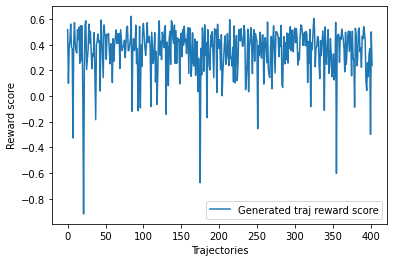

In [21]:
plt.figure()

plt.plot(episode_score, label = "Generated traj reward score")

plt.legend()

plt.xlabel('Trajectories')

plt.ylabel('Reward score')

In [22]:
print(round(np.mean(episode_score), 3), "+/-", round(np.std(episode_score),3))

0.354 +/- 0.191


Text(0, 0.5, 'Rolling reward score')

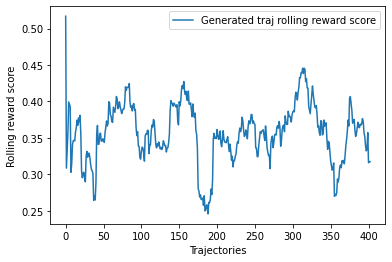

In [23]:
plt.figure()

plt.plot(rolling_score, label = "Generated traj rolling reward score")

plt.legend()

plt.xlabel('Trajectories')

plt.ylabel('Rolling reward score')

Text(0, 0.5, 'fTTC')

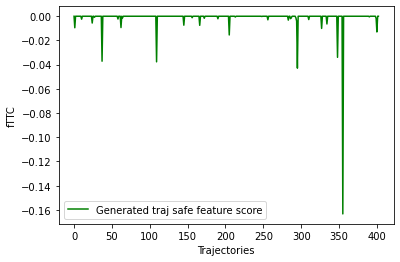

In [24]:
plt.figure()

plt.plot(score_safe, color = "green", label = "Generated traj safe feature score" )

plt.legend()

plt.xlabel('Trajectories')

plt.ylabel('fTTC')

In [25]:
print(round(np.mean(score_safe),3), "+/-", round(np.std(score_safe),3))

-0.001 +/- 0.009


Text(0, 0.5, 'fJerk')

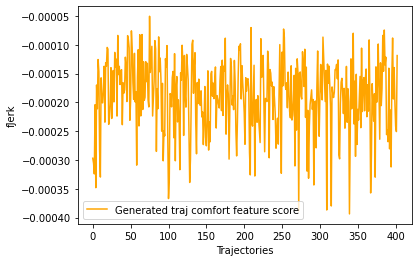

In [26]:
plt.figure()

plt.plot(score_comfort, color = "orange", label = "Generated traj comfort feature score")
plt.legend()

plt.xlabel('Trajectories')

plt.ylabel('fJerk')

In [27]:
print(round(np.mean(score_comfort),4), "+/-", round(np.std(score_comfort),4))

-0.0002 +/- 0.0001


Text(0, 0.5, 'fHdw')

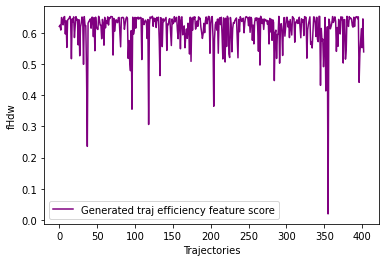

In [28]:
plt.figure()

plt.plot(score_efficiency, color = "purple", label = "Generated traj efficiency feature score")
plt.legend()

plt.xlabel('Trajectories')

plt.ylabel('fHdw')

In [29]:
print(round(np.mean(score_efficiency),3), "+/-", round(np.std(score_efficiency),3))

0.612 +/- 0.061


Text(0, 0.5, 'NRMSE(s)')

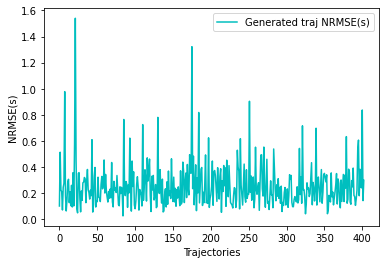

In [30]:
plt.figure()

plt.plot(-score_NRMSE, color = "c", label = "Generated traj NRMSE(s)")
plt.legend()

plt.xlabel('Trajectories')

plt.ylabel("NRMSE(s)")

Text(0, 0.5, 'Rolling NRMSE(s)')

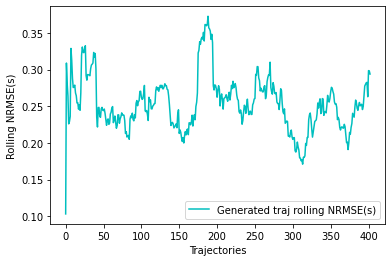

In [31]:
plt.figure()

plt.plot(-rolling_NRMSE, color = "c", label = "Generated traj rolling NRMSE(s)")
plt.legend()

plt.xlabel('Trajectories')

plt.ylabel("Rolling NRMSE(s)")

In [32]:
print(round(-np.mean(score_NRMSE),3), "+/-", round(np.std(score_NRMSE),3))

0.255 +/- 0.17


In [33]:
print(round(np.mean(score_RMSE),3), "+/-", round(np.std(score_RMSE),3))

3.631 +/- 3.289


In [34]:
print("Mean NRMSE:", -np.mean(score_NRMSE),
      "Min NRMSE:", -max(score_NRMSE),
      "Max NRMSE:", -min(score_NRMSE))

Mean NRMSE: 0.2551809501368611 Min NRMSE: 0.0273731028391914 Max NRMSE: 1.5399411291010976


In [36]:
def Find_best_trajs(episode_score):
    
    L = len(episode_score)
    best_trajs = [[-np.inf,0, 0],[-np.inf,1, 1], [-np.inf,2, 2], [-np.inf,3, 3],[-np.inf,4, 4],
                        [-np.inf,5, 5],[-np.inf,6, 6],[-np.inf,7, 7],[-np.inf,8, 8],[-np.inf,9, 9]]
    
    
    for i in range(L):
        current_score = episode_score[i]
        current_ind = car_fol_ids[i] #indice of the trajectory associated with this score. 
        for j in range(10):
            if current_score > best_trajs[j][0]:
                best_trajs[j][0] = current_score
                best_trajs[j][1] = current_ind
                best_trajs[j][2] = i
                break
                
    best_cf_id = [x[1] for x in best_trajs]
    best_inds = [x[2] for x in best_trajs]
                
    return best_trajs, best_cf_id, best_inds

best_trajs, best_cf_id, best_inds = Find_best_trajs(episode_score)


def Find_worst_trajs(episode_score):
    
    L = len(episode_score)
    worst_trajs = [[np.inf,0, 0],[np.inf,1, 1], [np.inf,2, 2], [np.inf,3, 3],[np.inf,4, 4],
                        [np.inf,5, 5],[np.inf,6, 6],[np.inf,7, 7],[np.inf,8, 8],[np.inf,9, 9]]
    
    
    for i in range(L):
        current_score = episode_score[i]
        current_ind = car_fol_ids[i] #indice of the trajectory associated with this score. 
        for j in range(10):
            if current_score < worst_trajs[j][0]:
                worst_trajs[j][0] = current_score
                worst_trajs[j][1] = current_ind
                worst_trajs[j][2] = i
                break
                
    worst_cf_id = [x[1] for x in worst_trajs]
    worst_inds = [x[2] for x in worst_trajs]
                
    return worst_trajs, worst_cf_id, worst_inds

worst_trajs, worst_cf_id, worst_inds = Find_worst_trajs(episode_score)

In [37]:
best_trajs

[[0.6219016973804984, 377, 84],
 [0.6054217604373291, 44, 325],
 [0.5766018472854405, 50, 264],
 [0.5746347086616813, 385, 354],
 [0.5533735719500084, 133, 308],
 [0.5487505064075179, 52, 309],
 [0.5411006819132012, 398, 391],
 [0.5390290606465409, 181, 340],
 [0.5313281536987459, 64, 178],
 [0.5304067817208621, 231, 385]]

In [38]:
worst_trajs

[[-0.9184362393035669, 235, 21],
 [-0.6749846084253206, 268, 175],
 [-0.6026928148397042, 320, 355],
 [-0.298953389099471, 191, 400],
 [-0.11078543920801381, 135, 339],
 [-0.08668776858343107, 218, 379],
 [-0.06467982809498922, 202, 118],
 [0.002221776400798146, 99, 204],
 [0.03302461443267316, 326, 239],
 [0.04344253424607697, 210, 395]]

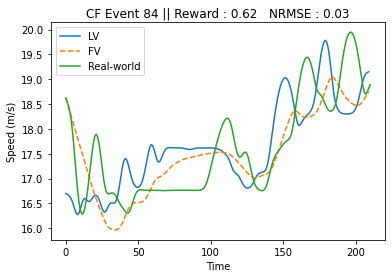

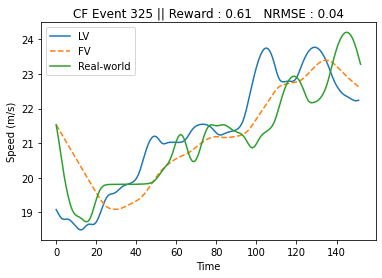

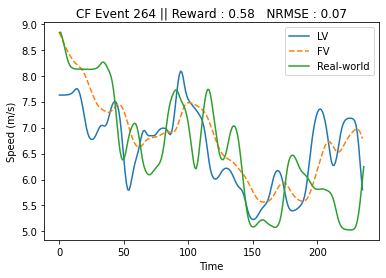

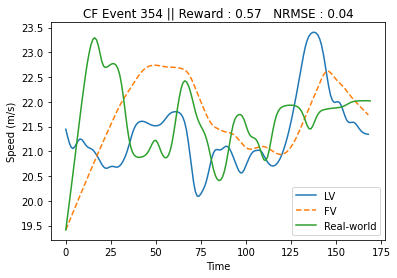

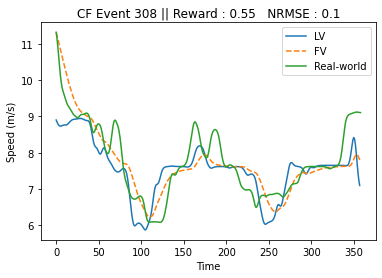

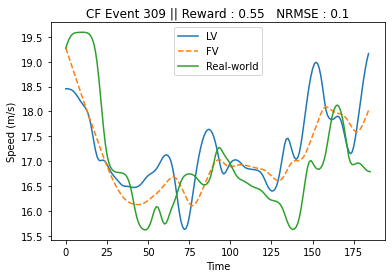

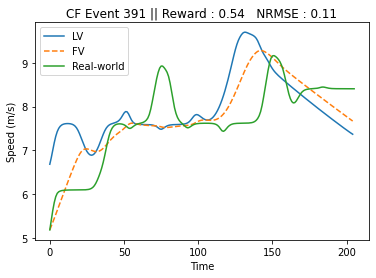

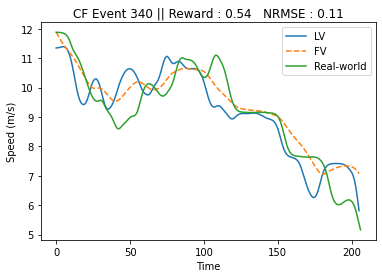

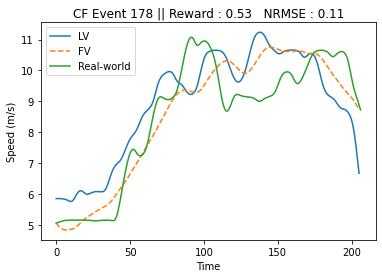

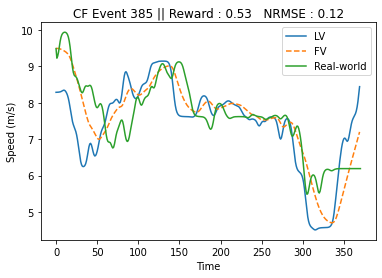

In [39]:
test = sio.loadmat('testSet.mat')['validationData']
# plot some CF speed (best trajs).

for i in best_inds:
    
    data = sim_data[i]
    j = car_fol_ids[i]
    real_data = test[j,0]
    
    score_traj = round(episode_score[i],2)
    nrmse_traj = -round(score_NRMSE[i],2)
    #score_ttc = round(score_s)
    
    plt.figure()
    plt.plot(data[:-1,0], label = 'LV')
    plt.plot(data[:-1,1], '--', label = 'FV')
    plt.plot(real_data[:,1], label = 'Real-world')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Speed (m/s)')
    
    title = "CF Event " + str(i) + " || " + "Reward : " + str(score_traj) + "   NRMSE : " + str(nrmse_traj)
    plt.title(title)

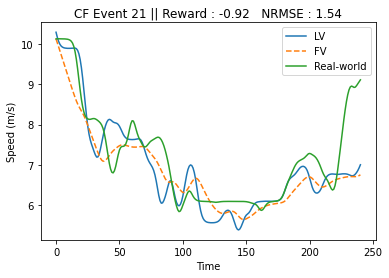

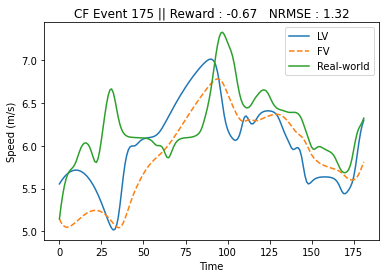

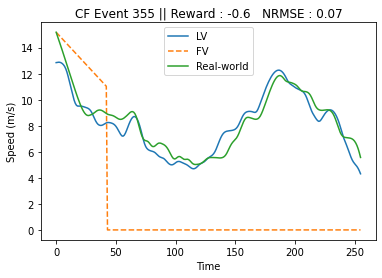

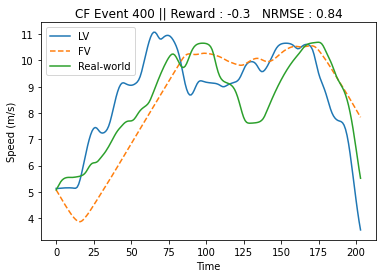

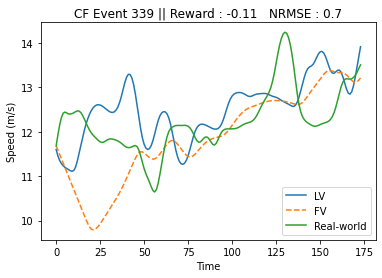

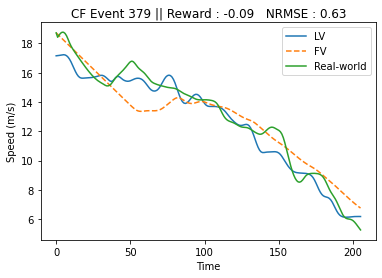

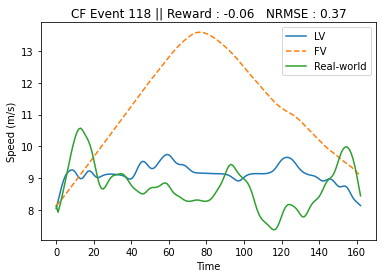

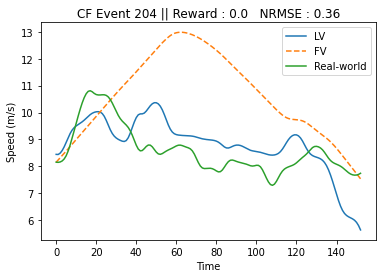

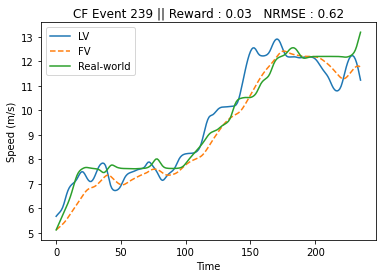

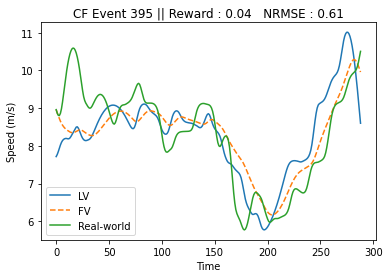

In [40]:
test = sio.loadmat('testSet.mat')['validationData']
# plot some CF speed (worst trajs).

for i in worst_inds:
    
    data = sim_data[i]
    j = car_fol_ids[i]
    real_data = test[j,0]
    
    score_traj = round(episode_score[i],2)
    nrmse_traj = -round(score_NRMSE[i],2)
    #score_ttc = round(score_s)
    
    plt.figure()
    plt.plot(data[:-1,0], label = 'LV')
    plt.plot(data[:-1,1], '--', label = 'FV')
    plt.plot(real_data[:-1,1], label = 'Real-world')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Speed (m/s)')
    
    title = "CF Event " + str(i) + " || " + "Reward : " + str(score_traj) + "   NRMSE : " + str(nrmse_traj)
    plt.title(title)

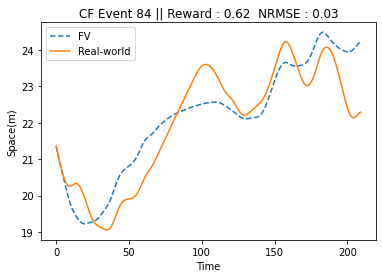

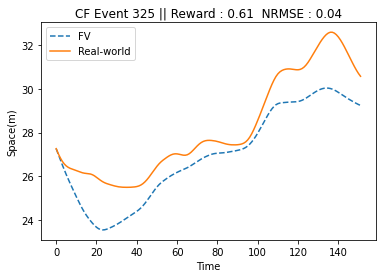

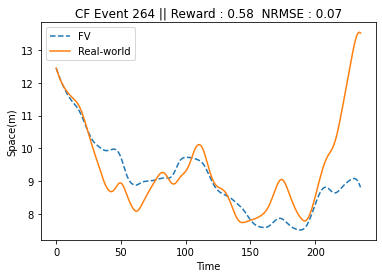

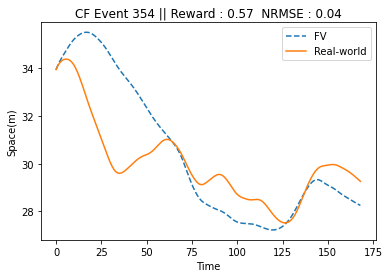

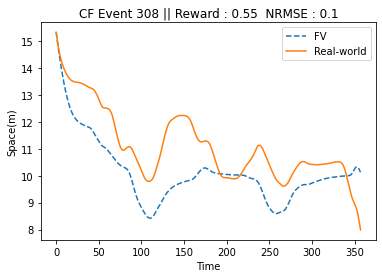

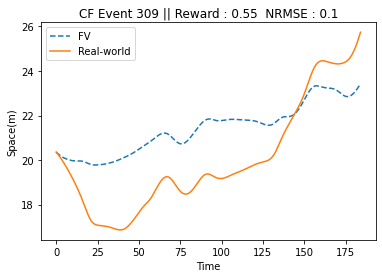

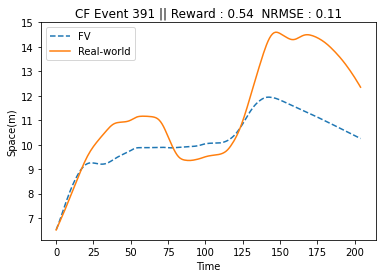

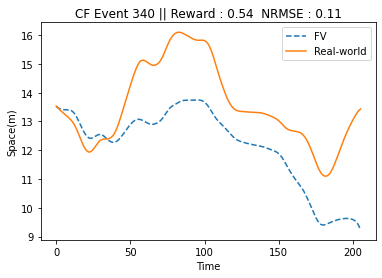

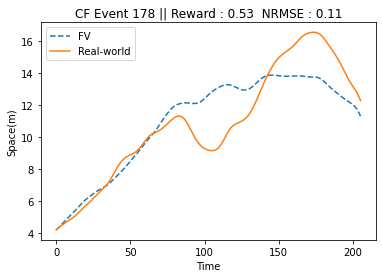

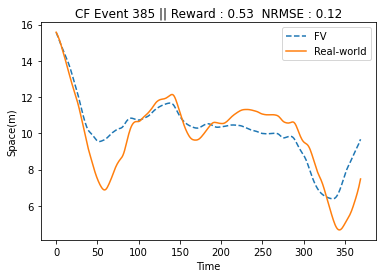

In [41]:
test = sio.loadmat('testSet.mat')['validationData']
# plot some CF spacing (best trajs).

for i in best_inds:
    data = sim_data[i]
    j = car_fol_ids[i]
    real_data = test[j,0]
    
    score_traj = round(episode_score[i],2)
    nrmse_traj = -round(score_NRMSE[i],2)
    score_ttc = round(score_safe[i], 2)
    
    plt.figure()
    #plt.plot(data[:-1,0], label = 'LV')
    plt.plot(data[:-1,2], '--', label = 'FV')
    plt.plot(real_data[:-1,0], label = 'Real-world')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Space(m)')
    
    title = "CF Event " + str(i) + " || " + "Reward : " + str(score_traj) +  "  NRMSE : " + str(nrmse_traj)
    plt.title(title)

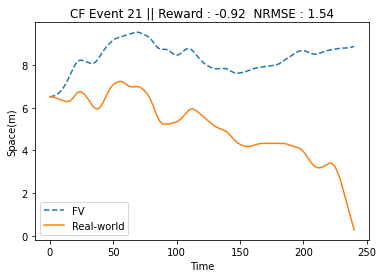

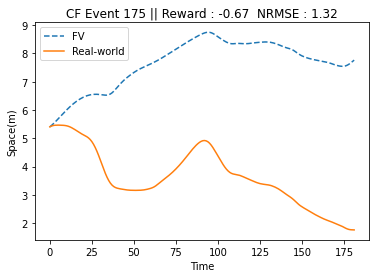

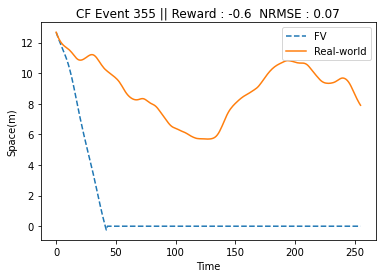

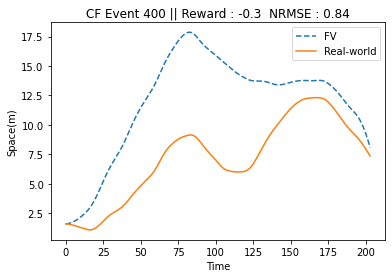

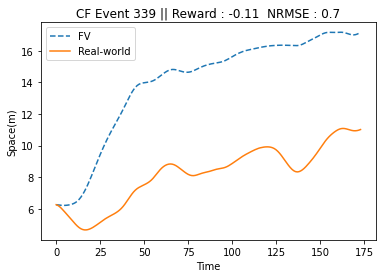

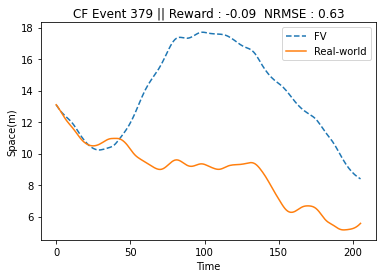

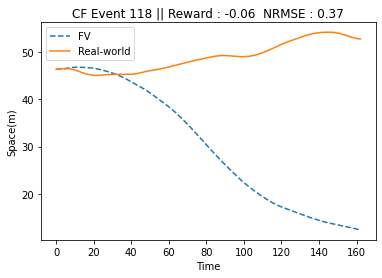

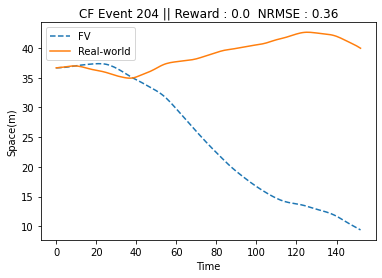

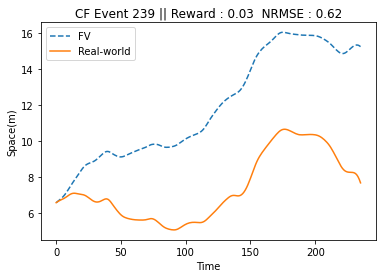

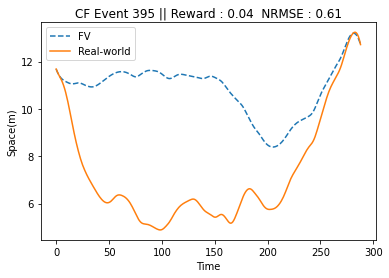

In [42]:
test = sio.loadmat('testSet.mat')['validationData']
# plot some CF spacing (worst trajs).

for i in worst_inds:
    data = sim_data[i]
    j = car_fol_ids[i]
    real_data = test[j,0]
    
    score_traj = round(episode_score[i],2)
    nrmse_traj = -round(score_NRMSE[i],2)
    score_ttc = round(score_safe[i], 2)
    
    plt.figure()
    #plt.plot(data[:-1,0], label = 'LV')
    plt.plot(data[:-1,2], '--', label = 'FV')
    plt.plot(real_data[:-1,0], label = 'Real-world')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Space(m)')
    
    title = "CF Event " + str(i) + " || " + "Reward : " + str(score_traj) +  "  NRMSE : " + str(nrmse_traj)
    plt.title(title)

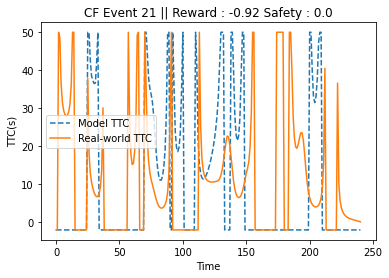

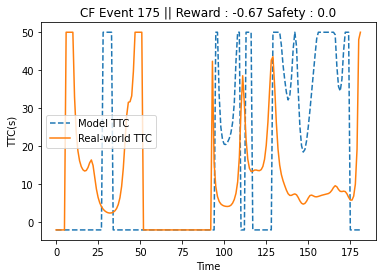

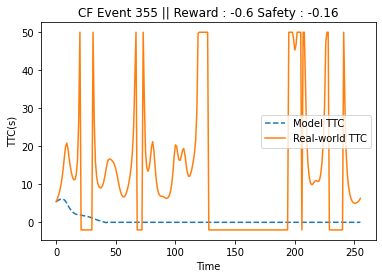

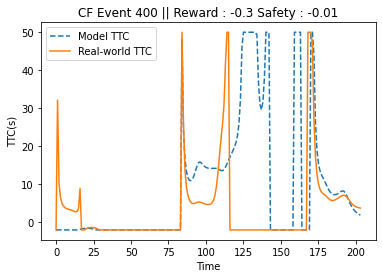

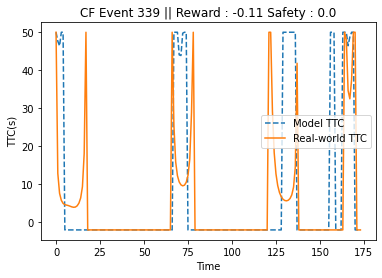

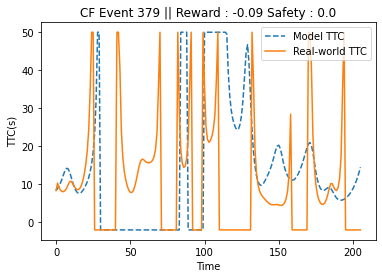

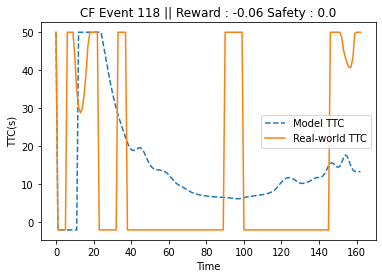

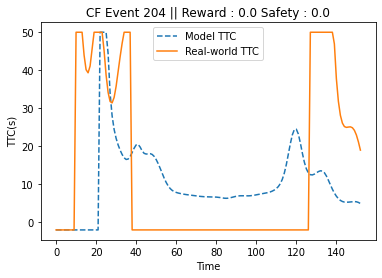

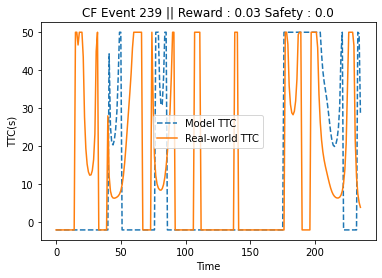

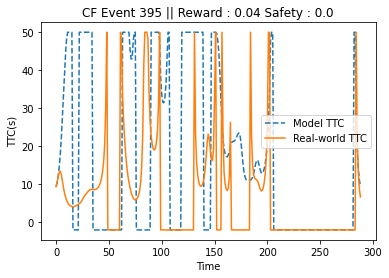

In [43]:
test = sio.loadmat('testSet.mat')['validationData']
# plot some CF TTC.

for i in worst_inds:
    data = sim_data[i]
    j = car_fol_ids[i]
    real_data = test[j,0]
    
    score_traj = round(episode_score[i],2)
    nrmse_traj = -round(score_NRMSE[i],2)
    score_ttc = round(score_safe[i], 2)
    
    real_TTC = []
    
    for k in real_data:
        ttc = -k[0]/k[2]
        
        if ttc < -2.0:
            ttc = -2.0
        
        if ttc > 50.0:
            ttc = 50.0
            
        real_TTC.append(ttc)
    
    sim_TTC = []
    
    for ttc2 in data[:,3]:
        if ttc2 < -2.0:
            ttc2 = -2.0
        
        if ttc2 > 50.0:
            ttc2 = 50.0
        
        sim_TTC.append(ttc2)
    
    plt.figure()
    #plt.plot(data[:-1,0], label = 'LV')
    plt.plot(sim_TTC[:-1], '--', label = 'Model TTC')
    plt.plot(real_TTC[:-1], label = 'Real-world TTC')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('TTC(s)')
    
    title = "CF Event " + str(i) + " || " + "Reward : " + str(score_traj) +  " Safety : " + str(score_ttc)
    plt.title(title)

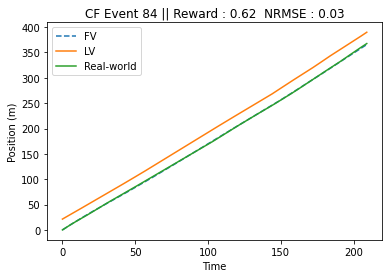

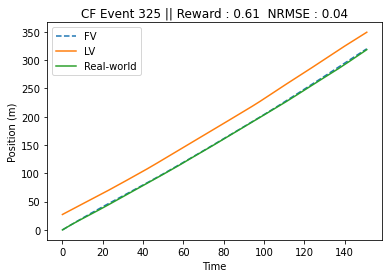

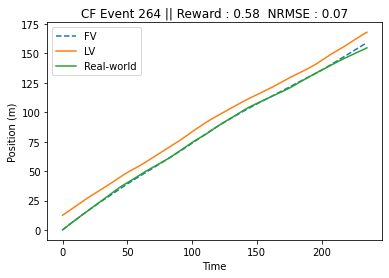

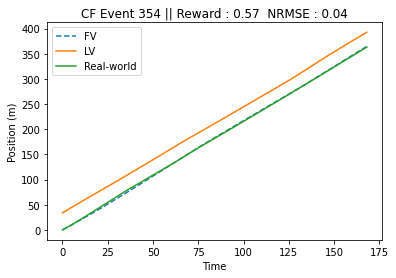

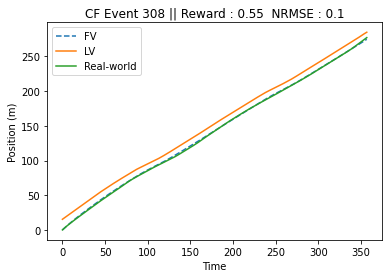

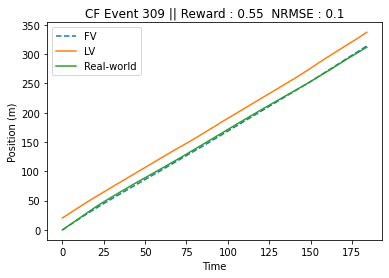

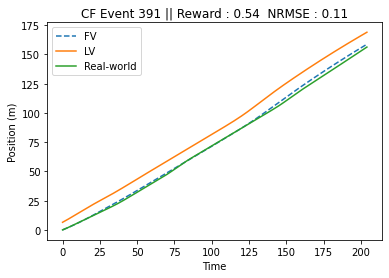

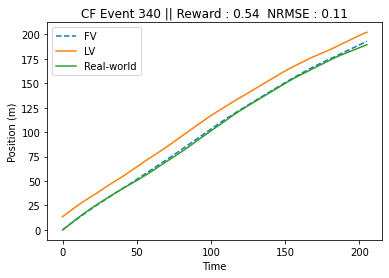

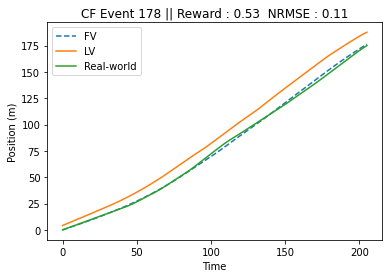

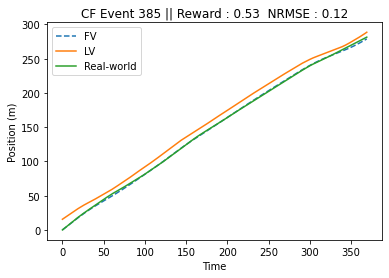

In [44]:
test = sio.loadmat('testSet.mat')['validationData']
# plot some car-following trajectories

for i in best_inds:
    data = pos_data[i]
    j = car_fol_ids[i]
    real_data = real_pos(test[j,0])
    
    score_traj = round(episode_score[i],2)
    nrmse_traj = -round(score_NRMSE[i],2)
    score_ttc = round(score_safe[i], 2)
    
    plt.figure()
    plt.plot(data[:-1,0], '--', label = 'FV')
    plt.plot(data[:-1,1], label = 'LV')
    plt.plot(real_data[:-1], label = 'Real-world')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Position (m)')
    
    title = "CF Event " + str(i) + " || " + "Reward : " + str(score_traj) +  "  NRMSE : " + str(nrmse_traj)
    plt.title(title)

In [61]:
#Code to test MULTIPLES MODELS at the same time. 

df_TTC_list, drivers_TTC, drivers_perc_TTC, aggressive_drivers, neutral_drivers, timid_drivers, flop3_ag, flop3_tim = driver_classifier_TTC()

#less_timid = [10, 18]
#less_aggressive = [2, 3]

driving_style = "timid" #Choose driving style.

for k in range(1):
    
    test = sio.loadmat('testSet.mat')['validationData']
    env = CarFollowingEnv_test()

    s_0 = env.reset()
    j_0 = env.car_fol_id
    
    if driving_style == "aggressive":
    
        while j_0 not in aggressive_drivers:
            s_0 = env.reset()
            j_0 = env.car_fol_id
            
    elif driving_style == "neutral":
        
        while j_0 not in neutral_drivers:
            s_0 = env.reset()
            j_0 = env.car_fol_id
    
    elif driving_style == "timid":
        
        while j_0 not in timid_drivers:
            s_0 = env.reset()
            j_0 = env.car_fol_id
    
            
    elif driving_style == "less_timid":
        
        while j_0 not in less_timid:
            s_0 = env.reset()
            j_0 = env.car_fol_id
            
    elif driving_style == "less_aggressive":
        
        while j_0 not in less_aggressive:
            s_0 = env.reset()
            j_0 = env.car_fol_id
            
    print("Random traj selected:",j_0)
    
    ######### REAL WORLD (HUMAN) ########
    
    s_HUMAN = s_0
    
    i = np.random.randint(900)
    X_train, y_train, X_test, y_test, df, df_test, LeaderSpeed = data_loader(i, j_0, False, 50, False, False)
    
    score = []
    score_s, score_e, score_c, a = [], [], [], [] # part objective scores
    
    for k in range(len(df_test.values)-1):
        
        action = df_test.values[k, 3]
        s_, reward, done, info = env.step(action)
        
     
        s_HUMAN = s_
        score.append(reward)
        score_s.append(info["fTTC"])
        score_e.append(info["fHdw"])
        score_c.append(info["fJerk"])
        a.append(action)
        
    # store traffic simulation data
    SimSpeedData_HUMAN = env.SimSpeedData
    SimSpaceData_HUMAN = env.SimSpaceData
    SimTTCData_HUMAN = env.SimTTCData
    
    Reward_HUMAN = score
    fTTC_HUMAN = score_s
    fHdw_HUMAN = score_e
    fJerk_HUMAN = score_c
    Jerk_HUMAN = [np.sqrt(-x*3600) for x in fJerk_HUMAN]
    actions_HUMAN = a
    
    ########## AIRL ############
    
    j = -np.inf
    
    while j != j_0:
        s_AIRL = env.reset()
        j = env.car_fol_id
    
    print("OUT OF AIRL ...")
    
    score = []
    score_s, score_e, score_c, score_nrmse, a = [], [], [], [], []  # part objective scores
    score_rmse = []
    collision_test = 0

    
    while True:
        # Add exploration noise
        action, _states = FINAL_AIRL.predict(s_AIRL)
    
        s_, reward, done, info = env.step(action)
        

        s_AIRL = s_
        score.append(reward)
        score_s.append(info["fTTC"])
        score_e.append(info["fHdw"])
        score_c.append(info["fJerk"])
        score_nrmse.append(info["fNRMSE"])
        score_rmse.append(info["RMSE"])
        a.append(action)
        
        
        if done:
            #duration = env.TimeLen
            #score /= duration  # normalize with respect to car-following length
            #score_s /= duration
            #score_e /= duration
            #score_c /= duration
            #score_nrmse /= duration
            #a /= duration

            if env.isCollision == 1:
                collision_test += 1
            break
        
    # store traffic simulation data
    SimSpeedData_AIRL = env.SimSpeedData
    SimSpaceData_AIRL = env.SimSpaceData
    SimTTCData_AIRL = env.SimTTCData
    SimPosData_AIRL = env.SimPosData
    LVPosData = env.LVPosData
    
    Reward_AIRL = score
    fTTC_AIRL = score_s
    fHdw_AIRL = score_e
    fJerk_AIRL = score_c
    NRMSE_AIRL = score_nrmse
    RMSE_AIRL = score_rmse
    Jerk_AIRL = [np.sqrt(-x*3600) for x in fJerk_AIRL]
    actions_AIRL = a
    
    print("Collision for AIRL?  ", collision_test)
    
    ########## GAIL ############
    
    j = -np.inf
    
    while j != j_0:
        s_GAIL = env.reset()
        j = env.car_fol_id
    
    print("OUT OF GAIL ...")
        
    score = []
    score_s, score_e, score_c, score_nrmse, a = [], [], [], [], []  # part objective scores
    score_rmse = []
    collision_test = 0

    
    while True:
        # Add exploration noise
        action, _states = FINAL_GAIL.predict(s_GAIL)
      
        s_, reward, done, info = env.step(action)
        

        s_GAIL = s_
        score.append(reward)
        score_s.append(info["fTTC"])
        score_e.append(info["fHdw"])
        score_c.append(info["fJerk"])
        score_nrmse.append(info["fNRMSE"])
        score_rmse.append(info["RMSE"])
        a.append(action)
        
        if done:
            #duration = env.TimeLen
            #score /= duration  # normalize with respect to car-following length
            #score_s /= duration
            #score_e /= duration
            #score_c /= duration
            #score_nrmse /= duration
            #a /= duration

            if env.isCollision == 1:
                collision_test += 1
            break
    
    # store traffic simulation data
    sim_LV = env.LVSpdData
    SimSpeedData_GAIL = env.SimSpeedData
    SimSpaceData_GAIL = env.SimSpaceData
    SimTTCData_GAIL = env.SimTTCData
    SimPosData_GAIL = env.SimPosData
    
    Reward_GAIL = score
    fTTC_GAIL = score_s
    fHdw_GAIL = score_e
    fJerk_GAIL = score_c
    NRMSE_GAIL = score_nrmse
    RMSE_GAIL = score_rmse
    Jerk_GAIL = [np.sqrt(-x*3600) for x in fJerk_GAIL]
    actions_GAIL = a
    
    print("Collision for GAIL?  ", collision_test)
    
    ########## RL ############
    
    j = -np.inf
    
    while j != j_0:
        s_RL = env.reset()
        j = env.car_fol_id
        
    print("OUT OF RL ...")
    
    score = []
    score_s, score_e, score_c, score_nrmse, a = [], [], [], [], []  # part objective scores
    score_rmse = []
    collision_test = 0

    
    while True:
        # Add exploration noise
        action, _states = MODEL_SAC.predict(s_RL)
        s_, reward, done, info = env.step(action)
        

        s_RL = s_
        score.append(reward)
        score_s.append(info["fTTC"])
        score_e.append(info["fHdw"])
        score_c.append(info["fJerk"])
        score_nrmse.append(info["fNRMSE"])
        score_rmse.append(info["RMSE"])
        a.append(action)
        
        
        if done:
            if env.isCollision == 1:
                collision_test += 1
            break
        
    # store traffic simulation data
    SimSpeedData_RL = env.SimSpeedData
    SimSpaceData_RL = env.SimSpaceData
    SimTTCData_RL = env.SimTTCData
    SimPosData_RL = env.SimPosData
    
    Reward_RL = score
    fTTC_RL = score_s
    fHdw_RL = score_e
    fJerk_RL = score_c
    NRMSE_RL = score_nrmse
    RMSE_RL = score_rmse
    Jerk_RL = [np.sqrt(-x*3600) for x in fJerk_RL]
    actions_RL = a
    
    print("Collision for RL?  ", collision_test)
    
    ########## FFNN ############
    
    j = -np.inf
    
    while j != j_0:
        s_FNN = env.reset()
        j = env.car_fol_id
        
    print("OUT OF FNN ...")
    
    score = []
    score_s, score_e, score_c, score_nrmse, a = [], [], [], [], []  # part objective scores
    score_rmse = []
    collision_test = 0

    
    while True:
        # Add exploration noise
        action = FINAL_FNN(s_FNN.reshape(1,3))
        s_, reward, done, info = env.step(action)
        

        s_FNN = s_
        score.append(reward)
        score_s.append(info["fTTC"])
        infHdw = tf.reshape(info["fHdw"], [1])
        score_e.append(infHdw)
        score_c.append(info["fJerk"][0])
        score_nrmse.append(info["fNRMSE"])
        score_rmse.append(info["RMSE"])
        action = tf.reshape(action, [1])
        a.append(action)
        
        
        if done:
            if env.isCollision == 1:
                collision_test += 1
            break
        
    # store traffic simulation data
    SimSpeedData_FNN = env.SimSpeedData
    SimSpaceData_FNN = env.SimSpaceData
    SimTTCData_FNN = env.SimTTCData
    SimPosData_FNN = env.SimPosData
    
    Reward_FNN = score
    fTTC_FNN = score_s
    fHdw_FNN = score_e
    fJerk_FNN = score_c
    NRMSE_FNN = score_nrmse
    RMSE_FNN = score_rmse
    Jerk_FNN = [np.sqrt(-x*3600) for x in fJerk_FNN]
    actions_FNN = a
    
    print("Collision for FNN?  ", collision_test)
    
    ########## RNN #############
    
    env = CarFollowingEnv_test_recurrent()
    
    j = -np.inf
    
    while j != j_0:
        s_RNN = env.reset()
        j = env.car_fol_id
        
    print("OUT OF RNN ...")
        
    score = Reward_HUMAN[0:50]
    score_s, score_e, score_c = fTTC_HUMAN[0:50], fHdw_HUMAN[0:50], fJerk_HUMAN[0:50] # part objective scores
    score_nrmse, score_rmse, a = [0]*50, [0]*50, actions_HUMAN[0:50]
    collision_test = 0

    
    while True:
        # Add exploration noise
        action = FINAL_RNN(s_RNN.reshape(1,50,3))
        
        s_, reward, done, info = env.step(action)
        
        s_RNN = s_
        score.append(reward)
        score_s.append(info["fTTC"])
        infHdw = tf.reshape(info["fHdw"], [1])
        score_e.append(infHdw)
        score_c.append(info["fJerk"][0])
        score_nrmse.append(info["fNRMSE"])
        score_rmse.append(info["RMSE"])
        action = tf.reshape(action, [1])
        a.append(action)
        
        
        if done:
            if env.isCollision == 1:
                collision_test += 1
            break
        
    # store traffic simulation data
    SimSpeedData_RNN = env.SimSpeedData
    SimSpaceData_RNN = env.SimSpaceData
    SimTTCData_RNN = env.SimTTCData
    
    Reward_RNN = score
    fTTC_RNN = score_s
    fHdw_RNN = score_e
    fJerk_RNN = score_c
    NRMSE_RNN = score_nrmse
    RMSE_RNN = score_rmse
    Jerk_RNN = [np.sqrt(-x*3600) for x in fJerk_RNN]
    actions_RNN = a
    
    print("Collision for RNN?  ", collision_test)
    
    ########## BC ############
    
    env = CarFollowingEnv_test()
    
    j = -np.inf
    
    while j != j_0:
        s_BC = env.reset()
        j = env.car_fol_id
    
    print("OUT OF BC ...")
        
    score = []
    score_s, score_e, score_c, score_nrmse, a = [], [], [], [], []  # part objective scores
    score_rmse = []
    collision_test = 0

    
    while True:
        # Add exploration noise
        action, _states = FINAL_BC.predict(s_BC)
        
        s_, reward, done, info = env.step(action)
        
     
        s_BC = s_
        score.append(reward)
        score_s.append(info["fTTC"])
        score_e.append(info["fHdw"])
        score_c.append(info["fJerk"])
        score_nrmse.append(info["fNRMSE"])
        score_rmse.append(info["RMSE"])
        a.append(action)
        
        
        if done:
            if env.isCollision == 1:
                collision_test += 1
            break
        
    # store traffic simulation data
    SimSpeedData_BC = env.SimSpeedData
    SimSpaceData_BC = env.SimSpaceData
    SimTTCData_BC = env.SimTTCData
    SimPosData_BC = env.SimPosData
    
    Reward_BC = score
    fTTC_BC = score_s
    fHdw_BC = score_e
    fJerk_BC = score_c
    NRMSE_BC = score_nrmse
    RMSE_BC = score_rmse
    Jerk_BC = [np.sqrt(-x*3600) for x in fJerk_BC]
    actions_BC = a
    
    print("Collision for BC?  ", collision_test)
    
    print("Done !")

Random traj selected: 197
OUT OF AIRL ...
Collision for AIRL?   0
OUT OF GAIL ...
Collision for GAIL?   0
OUT OF RL ...
Collision for RL?   0
OUT OF FNN ...
Collision for FNN?   0


C:\Users\Lucas Mtb\anaconda3\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


OUT OF RNN ...
Collision for RNN?   0
OUT OF BC ...
Collision for BC?   0
Done !


In [ ]:
#Traj 167 interesting. 
#Traj 361 good FNN spacing surprisingly.

Text(0, 0.5, 'Position (m)')

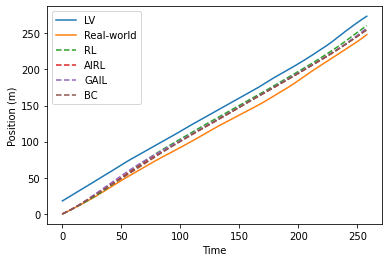

In [62]:
test = sio.loadmat('testSet.mat')['validationData']
# plot some car-following trjectories (x, t)

real_data = real_pos(test[j_0,0])    


plt.figure()

plt.plot(LVPosData[:-1], label = 'LV')
plt.plot(real_data[:-1], label = 'Real-world')

plt.plot(SimPosData_RL[:-1], '--', label = 'RL')
plt.plot(SimPosData_AIRL[:-1], '--', label = 'AIRL')
plt.plot(SimPosData_GAIL[:-1], '--', label = 'GAIL')
plt.plot(SimPosData_BC[:-1], '--', label = "BC")
#plt.plot(SimPosData_FNN[:-1], '--', label = 'FNN')



plt.legend()
plt.xlabel('Time')
plt.ylabel('Position (m)')

Text(0, 0.5, 'Space (m)')

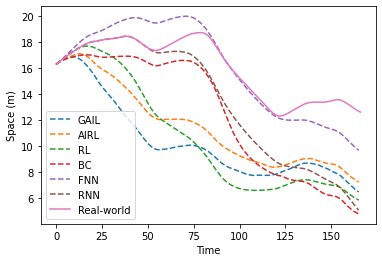

In [47]:
test = sio.loadmat('testSet.mat')['validationData']

real_data = test[j_0,0]
    
plt.figure()

plt.plot(SimSpaceData_GAIL[:-1], '--', label = 'GAIL')
plt.plot(SimSpaceData_AIRL[:-1], '--', label = 'AIRL')
plt.plot(SimSpaceData_RL[:-1], '--', label = 'RL')
plt.plot(SimSpaceData_BC[:-1], '--', label = 'BC')
plt.plot(SimSpaceData_FNN[:-1], '--', label = 'FNN')
plt.plot(SimSpaceData_RNN[:-1], '--', label = 'RNN')

plt.plot(real_data[:,0], label = 'Real-world')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Space (m)')
#title = "CF Event " + str(i) + " || " + "Reward : " + str(score_traj) + "   NRMSE : " + str(nrmse_traj)
#plt.title(title)

Text(0, 0.5, 'Speed (m/s)')

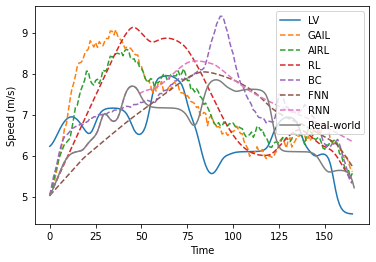

In [48]:
test = sio.loadmat('testSet.mat')['validationData']

real_data = test[j_0,0]
    
plt.figure()

plt.plot(sim_LV[:-1], label = 'LV')
plt.plot(SimSpeedData_GAIL[:-1], '--', label = 'GAIL')
plt.plot(SimSpeedData_AIRL[:-1], '--', label = 'AIRL')
plt.plot(SimSpeedData_RL[:-1], '--', label = 'RL')
plt.plot(SimSpeedData_BC[:-1], '--', label = 'BC')
plt.plot(SimSpeedData_FNN[:-1], '--', label = 'FNN')
plt.plot(SimSpeedData_RNN[:-1], '--', label = 'RNN')

plt.plot(real_data[:,1], label = 'Real-world')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Speed (m/s)')
    
#title = "CF Event " + str(i) + " || " + "Reward : " + str(score_traj) + "   NRMSE : " + str(nrmse_traj)
#plt.title(title)

Text(0, 0.5, 'Reward Score')

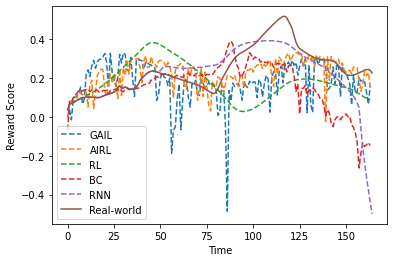

In [49]:
test = sio.loadmat('testSet.mat')['validationData']

real_data = test[j_0,0]
    
plt.figure()

plt.plot(Reward_GAIL[:-1], '--', label = 'GAIL')
plt.plot(Reward_AIRL[:-1], '--', label = 'AIRL')
plt.plot(Reward_RL[:-1], '--', label = 'RL')
plt.plot(Reward_BC[:-1], '--', label = 'BC')
#plt.plot(Reward_FNN[:-1], '--', label = 'FNN')
plt.plot(Reward_RNN[:-1], '--', label = 'RNN')

plt.plot(Reward_HUMAN[:], label = 'Real-world')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Reward Score')

C:\Users\Lucas Mtb\anaconda3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Text(0, 0.5, 'Safety Score')

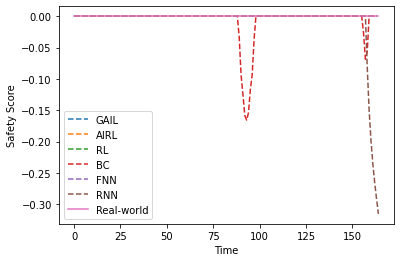

In [50]:
test = sio.loadmat('testSet.mat')['validationData']

real_data = test[j_0,0]
    
plt.figure()

plt.plot(fTTC_GAIL[:-1], '--', label = 'GAIL')
plt.plot(fTTC_AIRL[:-1], '--', label = 'AIRL')
plt.plot(fTTC_RL[:-1], '--', label = 'RL')
plt.plot(fTTC_BC[:-1], '--', label = 'BC')
plt.plot(fTTC_FNN[:-1], '--', label = 'FNN')
plt.plot(fTTC_RNN[:-1], '--', label = 'RNN')

plt.plot(fTTC_HUMAN[:], label = 'Real-world')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Safety Score')

In [51]:
def transfoTTC(SimTTCData):
    
    new_TTCData = []
    
    for ttc in SimTTCData:
        if ttc > 50.0:
            ttc = 50.0
            
        if ttc < -2.0:
            ttc = -2.0
        
        new_TTCData.append(ttc)
        
    return new_TTCData

Text(0, 0.5, 'TTC (s)')

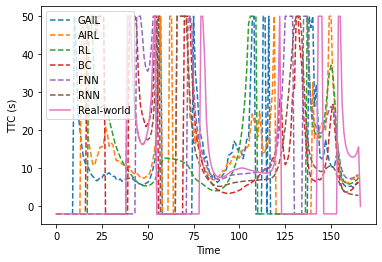

In [52]:
test = sio.loadmat('testSet.mat')['validationData']

real_data = test[j_0,0]

SimTTCData_GAIL = transfoTTC(SimTTCData_GAIL)
SimTTCData_AIRL = transfoTTC(SimTTCData_AIRL)
SimTTCData_RL = transfoTTC(SimTTCData_RL)
SimTTCData_BC = transfoTTC(SimTTCData_BC)
SimTTCData_FNN = transfoTTC(SimTTCData_FNN)
SimTTCData_HUMAN = transfoTTC(SimTTCData_HUMAN)
SimTTCData_RNN = transfoTTC(SimTTCData_RNN)

plt.figure()

plt.plot(SimTTCData_GAIL[:-1], '--', label = 'GAIL')
plt.plot(SimTTCData_AIRL[:-1], '--', label = 'AIRL')
plt.plot(SimTTCData_RL[:-1], '--', label = 'RL')
plt.plot(SimTTCData_BC[:-1], '--', label = 'BC')
plt.plot(SimTTCData_FNN[:-1], '--', label = 'FNN')
plt.plot(SimTTCData_RNN[:-1], '--', label = 'RNN')

plt.plot(SimTTCData_HUMAN[:], label = 'Real-world')
plt.legend()

plt.xlabel('Time')
plt.ylabel('TTC (s)')
    
#title = "CF Event " + str(i) + " || " + "Reward : " + str(score_traj) + "   NRMSE : " + str(nrmse_traj)
#plt.title(title)

C:\Users\Lucas Mtb\anaconda3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Text(0, 0.5, 'Efficiency Score')

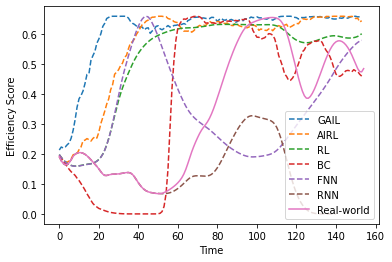

In [60]:
test = sio.loadmat('testSet.mat')['validationData']

real_data = test[j_0,0]
    
plt.figure()


plt.plot(fHdw_GAIL[:-1], '--', label = 'GAIL')
plt.plot(fHdw_AIRL[:-1], '--', label = 'AIRL')
plt.plot(fHdw_RL[:-1], '--', label = 'RL')
plt.plot(fHdw_BC[:-1], '--', label = 'BC')
plt.plot(fHdw_FNN[:-1], '--', label = 'FNN')
plt.plot(fHdw_RNN[:-1], '--', label = 'RNN')

plt.plot(fHdw_HUMAN[:], label = 'Real-world')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Efficiency Score')

Text(0, 0.5, 'Comfort Score')

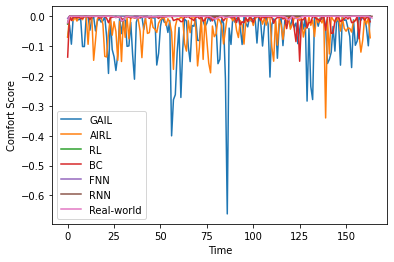

In [53]:
test = sio.loadmat('testSet.mat')['validationData']

real_data = test[j_0,0]
    
plt.figure()


plt.plot(fJerk_GAIL[:-1], label = 'GAIL')
plt.plot(fJerk_AIRL[:-1], label = 'AIRL')
plt.plot(fJerk_RL[:-1], label = 'RL')
plt.plot(fJerk_BC[:-1], label = 'BC')
plt.plot(fJerk_FNN[:-1], label = 'FNN')
plt.plot(fJerk_RNN[:-1], label = 'RNN')

plt.plot(fJerk_HUMAN[:], label = 'Real-world')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Comfort Score')

Text(0, 0.5, 'Jerk')

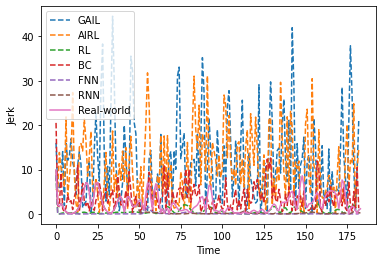

In [78]:
test = sio.loadmat('testSet.mat')['validationData']

real_data = test[j_0,0]
    
plt.figure()

plt.plot(Jerk_GAIL[:-1],"--", label = 'GAIL')
plt.plot(Jerk_AIRL[:-1], "--", label = 'AIRL')
plt.plot(Jerk_RL[:-1], "--", label = 'RL')
plt.plot(Jerk_BC[:-1], "--",label = 'BC')
plt.plot(Jerk_FNN[:-1], '--', label = 'FNN')
plt.plot(Jerk_RNN[:-1], '--', label = 'RNN')

plt.plot(Jerk_HUMAN[:], label = 'Real-world')
plt.legend()
plt.xlabel('Time')
plt.ylabel("Jerk")

Text(0, 0.5, 'Jerk')

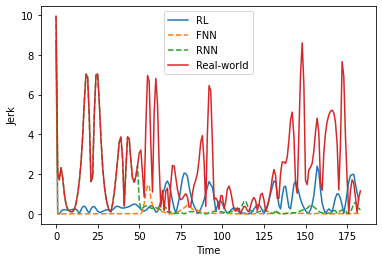

In [79]:
test = sio.loadmat('testSet.mat')['validationData']

real_data = test[j_0,0]
    
plt.figure()

#plt.plot(Jerk_GAIL[:-1], label = 'GAIL')
#plt.plot(Jerk_AIRL[:-1], label = 'AIRL')
plt.plot(Jerk_RL[:-1], label = 'RL')
#plt.plot(Jerk_BC[:-1], label = 'BC')
plt.plot(Jerk_FNN[:-1], '--', label = 'FNN')
plt.plot(Jerk_RNN[:-1], '--', label = 'RNN')

plt.plot(Jerk_HUMAN[:], label = 'Real-world')
plt.legend()
plt.xlabel('Time')
plt.ylabel("Jerk")

Text(0, 0.5, 'NRMSE(s) Score')

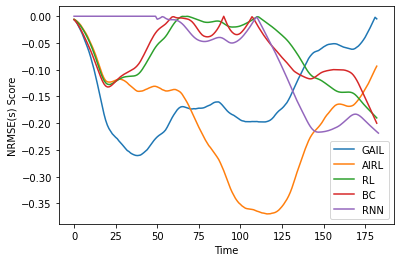

In [80]:
test = sio.loadmat('testSet.mat')['validationData']

real_data = test[j_0,0]
    
plt.figure()


plt.plot(NRMSE_GAIL[:-1], label = 'GAIL')
plt.plot(NRMSE_AIRL[:-1],  label = 'AIRL')
plt.plot(NRMSE_RL[:-1],  label = 'RL')
plt.plot(NRMSE_BC[:-1],  label = 'BC')
#plt.plot(NRMSE_FNN[:-1], label = 'FNN')
plt.plot(NRMSE_RNN[:-1],  label = 'RNN')

plt.legend()
plt.xlabel('Time')
plt.ylabel('NRMSE(s) Score')

Text(0, 0.5, 'RMSE(s)')

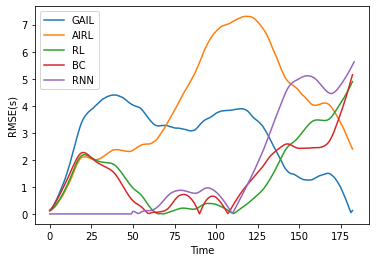

In [81]:
test = sio.loadmat('testSet.mat')['validationData']

real_data = test[j_0,0]
    
plt.figure()


plt.plot(RMSE_GAIL[:-1], label = 'GAIL')
plt.plot(RMSE_AIRL[:-1], label = 'AIRL')
plt.plot(RMSE_RL[:-1], label = 'RL')
plt.plot(RMSE_BC[:-1], label = 'BC')
#plt.plot(RMSE_FNN[:-1], label = 'FNN')
plt.plot(RMSE_RNN[:-1], label = 'RNN')

plt.legend()
plt.xlabel('Time')
plt.ylabel('RMSE(s)')